# Datasets COVID-19 Brazil

This notebook aims to concentrate methods to access, manage and store data about COVID-19 in Brazil

In [1]:
# General Imports:
import re
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import pickle
import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta 
import pytz # for timezone()
from babel.dates import format_date #Babel will automatically choose a date format that is appropriate for the requested locale. http://babel.pocoo.org/en/latest/dates.html

In [2]:
# Imports and Functions used for Web Scrapping and save data
import requests
from bs4 import BeautifulSoup, NavigableString
import socket
import ast #to eval python expression from strings
import ssl

#https://docs.python.org/3/howto/urllib2.html
# timeout in seconds
timeout = 10
socket.setdefaulttimeout(timeout)

#----------------------------------
# Functions
#----------------------------------

def rmfile(myfile):
    # Try to delete the file ##
    try:
        os.remove(myfile)
    except OSError as e:  ## if failed, report it back to the user ##
        print ("Error: %s - %s." % (e.filename, e.strerror))

#About pickle - https://stackoverflow.com/a/19201448
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    

def accent2html(textcontent):
    htmlcodes = ['&Aacute;', '&aacute;', '&Agrave;', '&Acirc;', '&agrave;', '&Acirc;', '&acirc;', '&Auml;', '&auml;', '&Atilde;', '&atilde;', '&Aring;', '&aring;', '&Aelig;', '&aelig;', '&Ccedil;', '&ccedil;', '&Eth;', '&eth;', '&Eacute;', '&eacute;', '&Egrave;', '&egrave;', '&Ecirc;', '&ecirc;', '&Euml;', '&euml;', '&Iacute;', '&iacute;', '&Igrave;', '&igrave;', '&Icirc;', '&icirc;', '&Iuml;', '&iuml;', '&Ntilde;', '&ntilde;', '&Oacute;', '&oacute;', '&Ograve;', '&ograve;', '&Ocirc;', '&ocirc;', '&Ouml;', '&ouml;', '&Otilde;', '&otilde;', '&Oslash;', '&oslash;', '&szlig;', '&Thorn;', '&thorn;', '&Uacute;', '&uacute;', '&Ugrave;', '&ugrave;', '&Ucirc;', '&ucirc;', '&Uuml;', '&uuml;', '&Yacute;', '&yacute;', '&yuml;', '&copy;', '&reg;', '&trade;', '&euro;', '&cent;', '&pound;', '&lsquo;', '&rsquo;', '&ldquo;', '&rdquo;', '&laquo;', '&raquo;', '&mdash;', '&ndash;', '&deg;', '&plusmn;', '&frac14;', '&frac12;', '&frac34;', '&times;', '&divide;', '&alpha;', '&beta;', '&infin']
    funnychars = ['\xc1','\xe1','\xc0','\xc2','\xe0','\xc2','\xe2','\xc4','\xe4','\xc3','\xe3','\xc5','\xe5','\xc6','\xe6','\xc7','\xe7','\xd0','\xf0','\xc9','\xe9','\xc8','\xe8','\xca','\xea','\xcb','\xeb','\xcd','\xed','\xcc','\xec','\xce','\xee','\xcf','\xef','\xd1','\xf1','\xd3','\xf3','\xd2','\xf2','\xd4','\xf4','\xd6','\xf6','\xd5','\xf5','\xd8','\xf8','\xdf','\xde','\xfe','\xda','\xfa','\xd9','\xf9','\xdb','\xfb','\xdc','\xfc','\xdd','\xfd','\xff','\xa9','\xae','\u2122','\u20ac','\xa2','\xa3','\u2018','\u2019','\u201c','\u201d','\xab','\xbb','\u2014','\u2013','\xb0','\xb1','\xbc','\xbd','\xbe','\xd7','\xf7','\u03b1','\u03b2','\u221e']

    newtext = ''
    for char in textcontent:
        if char not in funnychars:
            newtext = newtext + char
        else:
            newtext  = newtext + htmlcodes[funnychars.index(char)]
    return newtext

def html2accent(textcontent):
    
    htmlcodes = ['&ccedil', '&Ccedil', '\u00e9','\u00ea','\u00e3']
    funnychars = ['ç','Ç','é','ê','ã']
    
    for i,pathern in enumerate(htmlcodes):
        textcontent = re.sub(pathern, funnychars[i], textcontent)    
    
    return textcontent


## Web Scraping
---
### Voz da Comunidade newspaper
Coronavirus update panel in the favelas of Rio de Janeiro, made by Voz da Comunidade. The data started to be updated on 10/04/2020.

SOURCE OF INFORMATION ON CONFIRMED CASES AND CONFIRMED DEATHS   
    - Rio de Janeiro City Hall, Rio de Janeiro State Government, Zilda Arns Family Clinic, Pavão-Pavãozinho and Cantagalo Family Clinic, Germano Sinval Faria School Health Center - ENSP, Victor Valla Family Clinic, Maria do Family Clinic Socorro Silva e Souza, Valter Felisbino de Souza Family Clinic, João Candido Family Health Unit, Anthídio Dias da Silveira Family Clinic, Rinaldo De Lamare Family Clinic, Dr Albert Sabin Cms and SOS Providência Committee

SOURCE OF INFORMATION ABOUT RECOVERY  
    - Rio de Janeiro's city hall


If the access was successful: <Response [200]>
<Response [200]> 

Dicionario:  acumulados
Dicionario:  porDia


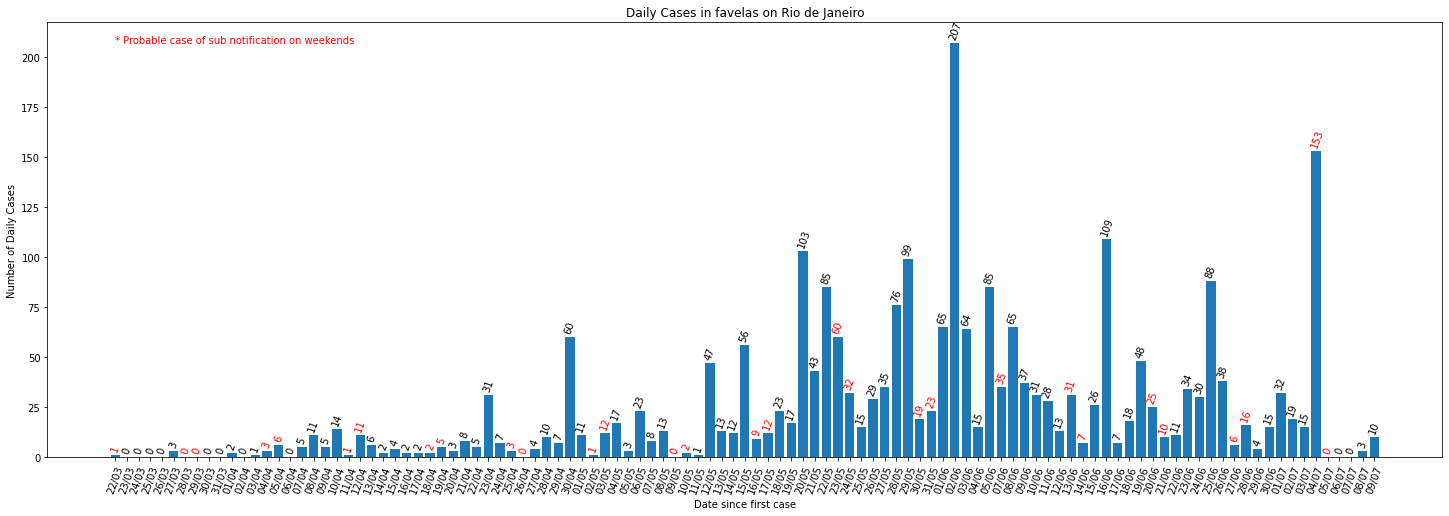

Dicionario:  comunidades


In [ ]:
# Set the URL you want to webscrape from
url = 'https://painel.vozdascomunidades.com.br' 

# Connect to the URL
response = requests.get(url)

print('If the access was successful: <Response [200]>')
print(response,'\n')

# Parse HTML and save to BeautifulSoup object
#soup = BeautifulSoup(response.text, "html.parser")
soup = BeautifulSoup(response.text, "lxml")

colors = ["black","black","black","black","black","red","red"]
visualization = True
for id,tag in enumerate(soup.find_all("script", recursive=True)):
    
     #print('\nId:',id,'Tag:',html2accent(tag.text.strip()))
     
     if 'porDia' in tag.text:
         for content in tag:
             name = content.name
             if isinstance(content, NavigableString):
                 s = html2accent(str(content))
                 s = s.replace("\n","")
                 s = s.replace("var ","")
                 s = s.replace("\\/","/")
                 s = s.replace('"24/03","25/04","26/03"','"24/03","25/03","26/03"') #fix bug date
                 values = s.strip().split(';')
                 values.remove('') #remove empty item
                 
                 for value in values:                     
                     var_name = value[:value.find('=')].strip()
                     print('Dicionario: ',var_name)
                     start = value.find('{')
                     end = value.find('}')
                     x = ast.literal_eval(value[start:end+1])
                     if "confirmados" in x:
                         x['confirmados'] = [int(i) for i in x['confirmados']]
                    
                     save_obj(x,var_name)   
                         
                     if visualization and var_name == 'porDia':
                         plt.xticks(rotation=70)
                         plt.bar(x['datas'], x['confirmados'], align='center')
                         plt.title('Daily Cases in favelas on Rio de Janeiro')
                         plt.xlabel('Date since first case');
                         plt.ylabel('Number of Daily Cases');

                         # Text on the top of each barplot
                         for i in range(len(x['datas'])):
                           weekday = datetime.strptime(x['datas'][i]+'/2020', "%d/%m/%Y").weekday()
                           if x['confirmados'][i] < 10:
                             plt.text(x = i-0.5, y = x['confirmados'][i]+2, s = str(x['confirmados'][i]), rotation=70, color=colors[weekday])
                           else:
                             plt.text(x = i-0.6, y = x['confirmados'][i]+2, s = str(x['confirmados'][i]), rotation=70, color=colors[weekday])
                            
                         plt.text(x = 0, y = max(x['confirmados']), s = '* Probable case of sub notification on weekends', color=colors[6])
                         #plt.savefig("Casos_"+var_name+".png", dpi=100)
                         fig = plt.gcf()
                         fig.set_size_inches(25, 8)
                         plt.show()
                        #  fig.savefig("Casos_"+var_name+".png", dpi=100)
                         

#### Read dictionaries and convert to dataframe

In [ ]:
df_vozcom_final = pd.merge(pd.DataFrame(load_obj('porDia')),
                           pd.DataFrame(load_obj('acumulados')).rename(columns={'confirmados': 'confirmados_acum', 'obitos': 'obitos_acum'}),
                           on='datas')

In [ ]:
df_vozcom_final.head()

,datas,confirmados,confirmados_acum,obitos_acum
0,22/03,1,1,0
1,23/03,0,1,0
2,24/03,0,1,0
3,25/03,0,1,0
4,26/03,0,1,0


### Worldometer COVID-19 Data

Worldometer manually analyzes, validates, and aggregates data from thousands of sources in real time and provides global **COVID-19 live statistics** for a **wide audience of caring people around the world**.

**Our data is also trusted and used by** the UK Government, Johns Hopkins CSSE, the Government of Thailand, the Government of Vietnam, the Government of Pakistan, Financial Times, The New York Times, Business Insider, BBC, and many others.

Worldometer is cited as a source in over 10,000 published books and in more than 6,000 professional journal articles and was voted as one of the best free reference websites by the **American Library Association** (ALA), the oldest and largest library association in the world.
How we work

We collect and process data around the clock, 24 hours a day, 7 days a week. Multiple updates per minute are performed on average by our team of analysts and researchers who validate the data from an ever-growing list of over 5,000 sources under the constant solicitation of users who alert us as soon as an official announcement is made anywhere around the world.
Sources and Methods

Our sources include Official Websites of Ministries of Health or other Government Institutions and Government authorities' social media accounts. Because national aggregates often lag behind the regional and local health departments' data, part of our work consists in monitoring thousands of daily reports released by local authorities. Our multilingual team also monitors press briefings' live streams throughout the day. Occasionally, we can use a selection of leading and trusted news wires with a proven history of accuracy in communicating the data reported by Governments in live press conferences before it is published on the Official Websites.
> Source: https://www.worldometers.info/coronavirus/about/

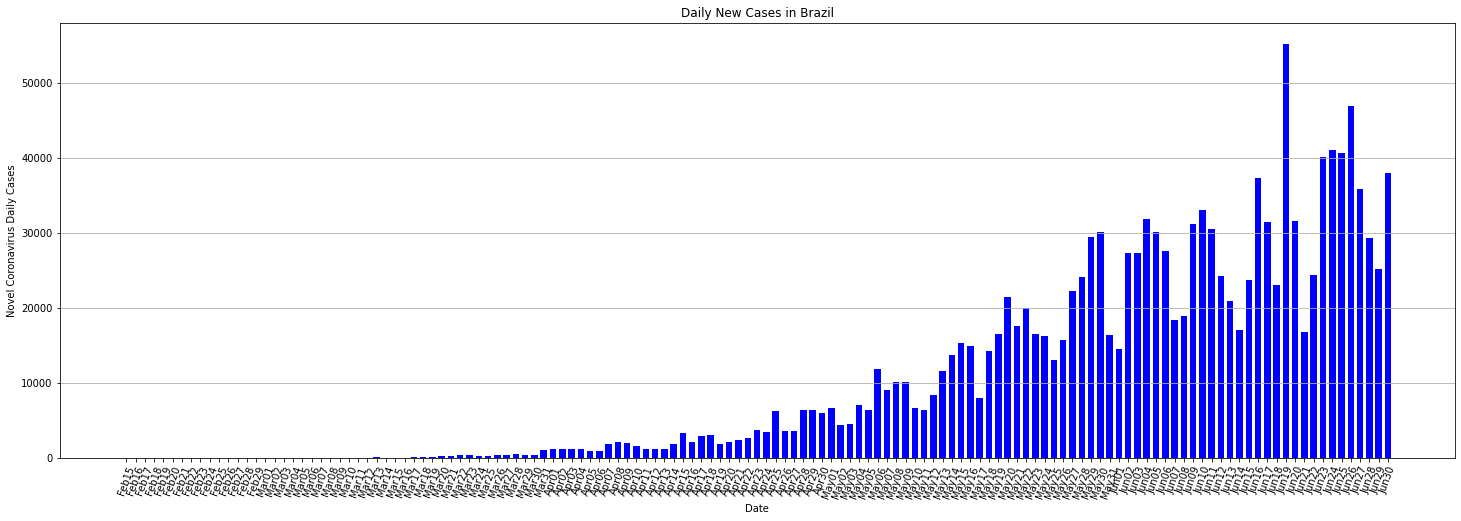

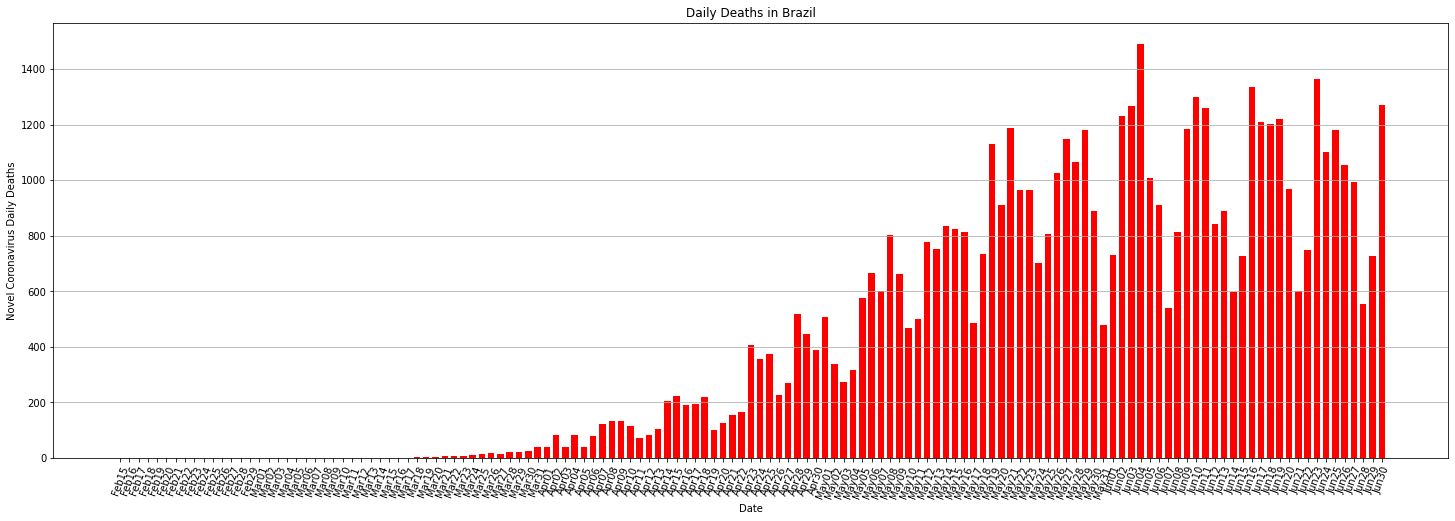

In [ ]:
# Set the URL you want to webscrape from
url = 'https://www.worldometers.info/coronavirus/country/brazil/' 

# Connect to the URL
response = requests.get(url)

print('If the access was successful: <Response [200]>')
print(response,'\n')

# Parse HTML and save to BeautifulSoup object
soup = BeautifulSoup(response.text, "lxml")
#soup = BeautifulSoup(response.content, 'html5lib') 
#print(soup.prettify())


colors = {'DailyCases':'blue','DailyDeaths':'red'}
titles = {'DailyCases':'Daily New Cases','DailyDeaths':'Daily Deaths'}
y_axes_titles = {'DailyCases':'Novel Coronavirus Daily Cases','DailyDeaths':'Novel Coronavirus Daily Deaths'}

visualization = True
for id,tag in enumerate(soup.find_all("script", recursive=True)):
     if 'Daily New Cases'in tag.text or 'Daily Deaths' in tag.text:
       # descendants (all of a tag’s children, recursively)      
       for content in tag.descendants:
         if isinstance(content, NavigableString):
            daily_cases = {}           
            m = re.search(r"xAxis: {", tag.text)
            if m is not None:
              start = tag.text[m.start():].find('[')
              end = tag.text[m.start():].find(']')
              daily_cases['date'] = ast.literal_eval(tag.text[m.start()+start:m.start()+end+1].replace('\n','').replace(' ',''))
            
            m = re.search(r"series: \[{", tag.text)
            if m is not None:
              start = tag.text[m.start():].find('{')
              end = tag.text[m.start():].find('},')
              s = tag.text[m.start()+start:m.start()+end+1].replace('\n','').replace(' ','').replace('false','False').replace('null','0')
              
              for word in  re.finditer(r"\w*:",s):
                s = s.replace(word.group(),'"'+word.group()[:-1]+'":')
              x = ast.literal_eval(s)
              daily_cases['daily_cases']  = x['data'] 
            
            save_obj(daily_cases,x['name'])   
                         
            if visualization:
                plt.xticks(rotation=70);
                plt.bar(daily_cases['date'], daily_cases['daily_cases'], align='center', width=0.7, color=colors[x['name']])
                plt.title(titles[x['name']]+' in Brazil')
                plt.xlabel('Date');
                plt.ylabel(y_axes_titles[x['name']]);
                plt.grid(axis='y')
                
                fig = plt.gcf()
                fig.set_size_inches(25,8)
                plt.show()
              #  fig.savefig("Casos_"+var_name+".png", dpi=100)


#### Read dictionaries and convert to dataframe

In [ ]:
df_wordometer_final = pd.merge(pd.DataFrame(load_obj('DailyCases')),
                           pd.DataFrame(load_obj('DailyDeaths')).rename(columns={'daily_cases': 'daily_deaths'}),
                           on='date')
df_wordometer_final

,date,daily_cases,daily_deaths
0,Feb15,0,0
1,Feb16,0,0
2,Feb17,0,0
3,Feb18,0,0
4,Feb19,0,0
...,...,...,...
132,Jun26,46907,1055
133,Jun27,35887,994
134,Jun28,29313,555
135,Jun29,25234,727


### The Brazilian Ministry of Health - Official data from the Panel of Coronavirus  Brazil

This panel was developed to be the official vehicle of communication on the epidemiological situation of COVID-19 in Brazil.

The process of updating data on cases and deaths confirmed by COVID-19 in Brazil is carried out daily by the Ministry of Health through official information provided by the State Health Departments of the 27 Brazilian Federative Units. The data provided by the states are consolidated and made publicly available every day, around 19h.

The process of updating information in municipalities, states, and at the federal level is dynamic and complex. Data reported daily is subject to change. Considering the plurality of each Brazilian municipality with regard to population size, infrastructure, and organization of health services, in addition to all the challenges that the COVID-19 pandemic imposes, it is possible that there will be changes in the number of cases or deaths as result errors or delays in the transfer of information.

At the municipal level, the data for the current day may be less than the previous day: this is because the municipality of notification is not necessarily the same place of residence of the notified case of death. Thus, upon completing the investigation process for each occurrence individually, the Municipal and State Health Secretariats have the autonomy to correct the information and pass it on to the Ministry of Health.

Cases and deaths are updated by the notification date. The Ministry of Health has been working together with the State and Municipal Health Secretariats to disseminate these indicators.

> Source: https://covid.saude.gov.br

In [3]:
# install chromium, its driver, and selenium
!apt install chromium-chromedriver
!pip install selenium

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension adobe-flashplugin
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 33 not upgraded.
Need to get 75.5 MB of archives.
After this operation, 256 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 83.0.4103.61-0ubuntu0.18.04.1 [1,119 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 83.0.410

In [4]:
# set options to be headless
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

# set options to be headless
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# function to define date of source file
def datefile():
  #https://www.alura.com.br/artigos/lidando-com-datas-e-horarios-no-python
  #https://tutorial.eyehunts.com/python/python-datetime-now-module-timezone-example/
  update_time = datetime.strptime(datetime.now(pytz.timezone('America/Sao_Paulo')).strftime('%Y-%m-%d 19:15'), "%Y-%m-%d %H:%M")

  # using now() to get current time 
  current_time = datetime.strptime(datetime.now(pytz.timezone('America/Sao_Paulo')).strftime('%Y-%m-%d %H:%M'), "%Y-%m-%d %H:%M")

  if current_time > update_time:
    datefile = datetime.now(pytz.timezone('America/Sao_Paulo'))
  else:
    datefile = (datetime.now(pytz.timezone('America/Sao_Paulo')) - timedelta(days = 1))

  return format_date(datefile, "ddMMMYYYY",locale='pt_BR').replace('.','')
  
# function to check downloaded files:
def get_non_temp_len(download_dir):
    non_temp_files = [i for i in os.listdir(download_dir) if not (i.endswith('.tmp') or i.endswith('.crdownload'))]
    return len(non_temp_files)

# check existence before try to download file:
if not os.path.exists('HIST_PAINEL_COVIDBR_'+ datefile() +'.xlsx'):
  # open it, go to a website, and get results
  wd = webdriver.Chrome('chromedriver',options=options)

  try:
    wd.get("https://covid.saude.gov.br")
    time.sleep(5)
    print("Server ready")
  except (socket.error, urllib3_exceptions.MaxRetryError,
                  exceptions.UnexpectedResponseCode):
    print("Server not ready")
    raise
  except Exception:
    raise

  #print(wd.page_source)  # results

  download_dir = os.getcwd()
  original_count = get_non_temp_len(download_dir) # get the file count at the start

  # About how to handle web apps wich using AJAX techniques. Apply Selenium Waits - https://selenium-python.readthedocs.io/waits.html 
  try:
    # download spreadsheet using clickable button:
    #WebDriverWait(wd,20).until(EC.presence_of_element_located((By.XPATH,"//ion-button[@class='btn-white md button button-solid button-has-icon-only ion-activatable ion-focusable hydrated']"))).click()
    download_button = WebDriverWait(wd,20).until(
        EC.element_to_be_clickable((By.XPATH,"//ion-button[@class='btn-white md button button-solid button-has-icon-only ion-activatable ion-focusable hydrated']"))
        )
    download_button.click()
  except TimeoutException:
    print('[!] Timeout: element not found')
    raise  
  finally:
    # Waiting for a download process to complete using Chrome web driver - https://stackoverflow.com/a/62559494
    print('Waiting download process.',end='')
    while original_count == get_non_temp_len(download_dir):
      print('.',end='')
      time.sleep(1) # wait for file count to change
    print('\nDownload complete!')
    wd.quit()

# read downloaded file:
covid_hist = pd.read_excel('HIST_PAINEL_COVIDBR_'+ datefile() +'.xlsx')
covid_hist.head()

Server ready
Waiting download process......
Download complete!


,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125,0,0,0,0,NaN,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125,1,1,0,0,NaN,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125,1,0,0,0,NaN,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125,1,0,0,0,NaN,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125,2,1,0,0,NaN,NaN,NaN


In [11]:
from google.colab import files

#Export data to csv and save locally:

df_tmp = covid_hist.loc[:,['regiao','coduf','data','casosNovos']]
df_tmp.rename(columns={'regiao':'Region','coduf':'Code','data':'Date','casosNovos':'DailyCase'},inplace=True)
df_tmp.drop(covid_hist[covid_hist.casosAcumulado.eq(0).values].index,inplace=True) #Drop lines until first case

#save pandas output as csv
df_tmp.to_csv('HIST_PAINEL_COVIDBR_'+ datefile() +'.csv', sep = ',', index=False)
#Bosnia and Herzegovina,BIH,"Mar 6, 2020",2

files.download('HIST_PAINEL_COVIDBR_'+ datefile() +'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

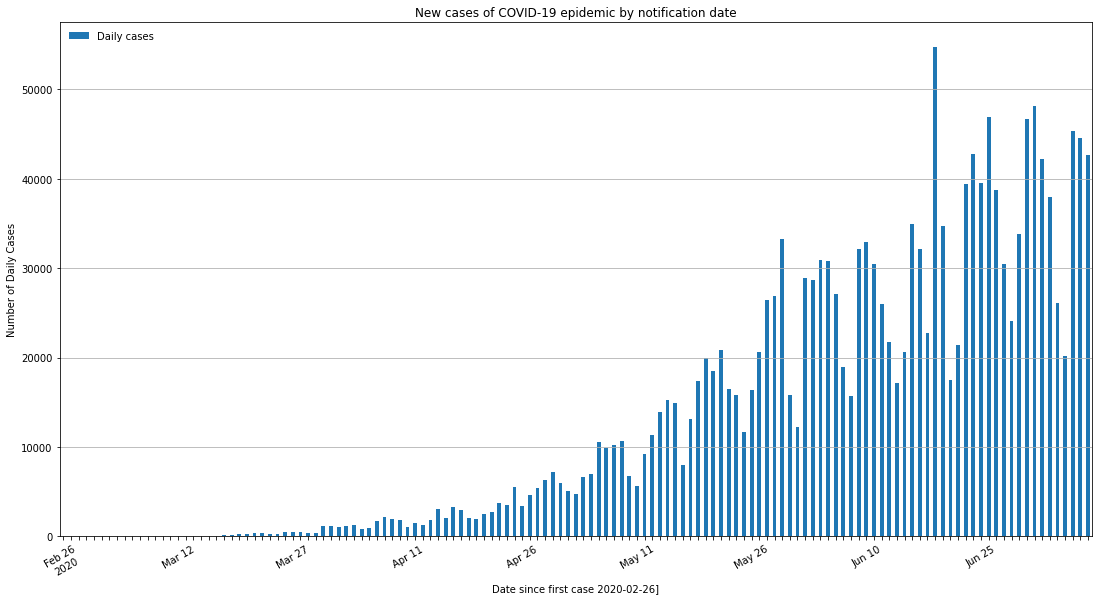

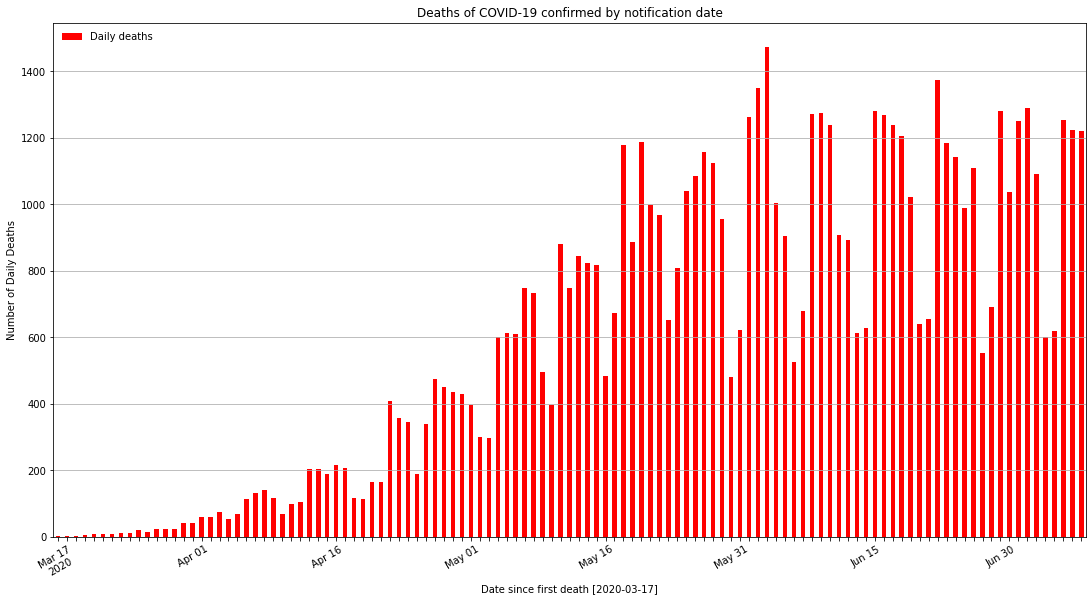

In [ ]:
#View data:
index = covid_hist[covid_hist.regiao == 'Brasil'].index
df_region = covid_hist.loc[index,['data','casosNovos','obitosNovos']]

#set date as index
df_region.set_index('data',inplace=True)

#Plot new cases
index_start = df_region[df_region.casosNovos.gt(0)].index[0]
df_region = df_region[df_region.index >= index_start] #Drop lines until first case

ax = df_region.casosNovos.plot(kind='bar');
ticklabels = ['']*len(df_region.casosNovos.index) # Every 15th ticklable shows the month and day 
ticklabels[::15] = [item.strftime('%b %d') for item in df_region.casosNovos.index[::15]] # Every 365th ticklabel includes the year 
ticklabels[::365] = [item.strftime('%b %d\n%Y') for item in df_region.casosNovos.index[::365]] 
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels)) 


# specify the lines and labels of the first legend
ax.legend(['Daily cases'],loc='upper left', frameon=False)
ax.grid(axis='y')

ax.set_title('New cases of COVID-19 epidemic by notification date')
ax.set_ylabel('Number of Daily Cases')
ax.set_xlabel('Date since first case '+df_region.index[0].strftime("%Y-%m-%d")+']');
plt.gcf().autofmt_xdate()
plt.xticks(ha='center') 
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

#Plot deaths
index_start = df_region[df_region.obitosNovos.gt(0)].index[0]
df_region = df_region[df_region.index >= index_start] #Drop lines until first death

ax = df_region.obitosNovos.plot(kind='bar',color='red');
ticklabels = ['']*len(df_region.obitosNovos.index) # Every 15th ticklable shows the month and day 
ticklabels[::15] = [item.strftime('%b %d') for item in df_region.obitosNovos.index[::15]] # Every 365th ticklabel includes the year 
ticklabels[::365] = [item.strftime('%b %d\n%Y') for item in df_region.obitosNovos.index[::365]] 
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels)) 

# specify the lines and labels of the first legend
ax.legend(['Daily deaths'],loc='upper left', frameon=False)

ax.grid(axis='y')

ax.set_title('Deaths of COVID-19 confirmed by notification date')
ax.set_ylabel('Number of Daily Deaths')
ax.set_xlabel('Date since first death ['+df_region.index[0].strftime("%Y-%m-%d")+']');
plt.gcf().autofmt_xdate()
plt.xticks(ha='center') 
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


## CSV Files
---

### Transparency Portal - Civil Registry

The permanent update of the number of death records in the midst of the Covid-19 pandemic is an initiative of the Civil Registry Offices of Brazil, which in this way reinforce their commitment to transparency with society, in compliance with [Ordinance No. 57/20](https://atos.cnj.jus.br/atos/detalhar/3252), of the [National Council of Justice (CNJ)](https://www.cnj.jus.br/), which also included the pandemic for the new coronavirus in the [National Observatory of Environmental, Economic and Social Issues of High Complexity, of Great Impact and Repercussion](https://observatorionacional.cnj.jus.br/observatorionacional/), formed jointly by the CNJ and the [National Council of the Public Ministry (CNMP)](https://www.cnmp.mp.br/portal/).
> Source: https://transparencia.registrocivil.org.br/especial-covid

In [ ]:
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO


url = "https://transparencia.registrocivil.org.br/covid/obitos-2019.csv"

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

# Pretend a browser:
r = requests.get(url, headers=header)

#Create Pandas DataFrame from a string - https://stackoverflow.com/a/22605281
df_regcivil_2019 = pd.read_csv(StringIO(r.text), sep=",")


url = "https://transparencia.registrocivil.org.br/covid/obitos-2020.csv"

# Pretend a browser:
r = requests.get(url, headers=header)

#Create Pandas DataFrame from a string - https://stackoverflow.com/a/22605281
df_regcivil_2020 = pd.read_csv(StringIO(r.text), sep=",")



In [ ]:
print(df_regcivil_2019.head())
df_regcivil_2020.head()

   uf tipo_doenca local_obito faixa_etaria sexo  total
0  AC      OUTRAS   DOMICILIO          < 9    F      8
1  AC      OUTRAS   DOMICILIO          < 9    M     15
2  AC      OUTRAS    HOSPITAL          < 9    F     28
3  AC      OUTRAS    HOSPITAL          < 9    M     56
4  AC      OUTRAS    IGNORADO          < 9    M      1


,uf,tipo_doenca,local_obito,faixa_etaria,sexo,total
0,AC,OUTRAS,DOMICILIO,< 9,F,3
1,AC,OUTRAS,DOMICILIO,< 9,M,3
2,AC,OUTRAS,HOSPITAL,< 9,F,20
3,AC,OUTRAS,HOSPITAL,< 9,M,20
4,AC,OUTRAS,OUTRO,< 9,F,3


### OpenDataSUS - Data from the Coronavirus Panel Brazil  
><font color='red'>Unfortunately, this dataset source updated only until June 7, 2020</font>

>Unfortunately, this dataset source updated only until June 7, 2020  

The Ministry of Health disseminates consolidated data on cases and deaths confirmed by COVID-19 registered by the State and Municipal Health Secretariats on a daily basis.

The data comes from both the information systems of the Ministry of Health (e-SUS NOTIFICA and SIVEP-GRIPE), as well as local systems for recording information on the management of states and municipalities.

Two spreadsheets are available daily:

• HOJE_PAINEL_COVIDBR_DDMMMYYYY: contains data for the day.

• HIST_PAINEL_COVIDBR_DDMMMYYYY: contains the complete history, since the first confirmed case in Brazil.

The total accumulated cases and deaths up to the date of disclosure are available for Brazil, Macroregions, UF, Health Regions and Municipalities. Information on the epidemiological week, TCU population 2019 (parameter for calculating incidence and mortality rates) and total cases recovered and being followed up are also available.

**Limitations**

The process of updating information in municipalities, states and at the federal level is dynamic and complex. Data reported daily is subject to change. Considering the plurality of each Brazilian municipality with regard to population size, infrastructure and organization of health services, in addition to all the challenges that the COVID-19 pandemic imposes, it is possible that there will be changes in the number of cases or deaths as a result errors or delays in the transfer of information.

At the municipal level, the data for the current day may be less than the previous day: this is because the municipality of notification is not necessarily the same place of residence of the notified case or death. Thus, upon completing the investigation process for each occurrence individually, the Municipal and State Health Secretariats have the autonomy to correct the information and pass it on to the Ministry of Health.

Cases and deaths are updated by notification date. The Ministry of Health has been working together with the State and Municipal Health Secretariats to disseminate these indicators.

The available data are available by date of confirmation of the case and death, and it is not possible to discriminate the dates of notification, onset of symptoms and occurrence of death.

These data are preliminary, subject to evaluation. The data are forwarded daily until 6 PM by the State Health Secretariats, and undergo an inconsistency assessment process by the Ministry of Health.

For more information, consult the Coronavirus Brasil panel, available through the link: https://covid.saude.gov.br/
> Source: https://opendatasus.saude.gov.br/dataset/painel-da-covid-19

In [ ]:
import os, ssl

#https://medium.com/@moreless/how-to-fix-python-ssl-certificate-verify-failed-97772d9dd14c
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
  ssl._create_default_https_context = ssl._create_unverified_context

covid_hist = pd.read_excel('https://opendatasus.saude.gov.br/dataset/db319195-71a8-4a5f-bf78-aaaedddf2d56/resource/297fc549-d614-4c16-a652-a178dca18a60/download/hist_painel_covidbr_07jun2020.xlsx')

In [ ]:
#View data:
covid_hist

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125,1,0,0,0,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125,1,0,0,0,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125,1,0,0,0,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125,2,1,0,0,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-03-01,10,210147125,2,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168824,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-06-03,23,3015268,12020,764,191,14,NaN,NaN
168825,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-06-04,23,3015268,12923,903,196,5,NaN,NaN
168826,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-06-05,23,3015268,14208,1285,202,6,NaN,NaN
168827,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-06-06,23,3015268,15850,1642,208,6,NaN,NaN


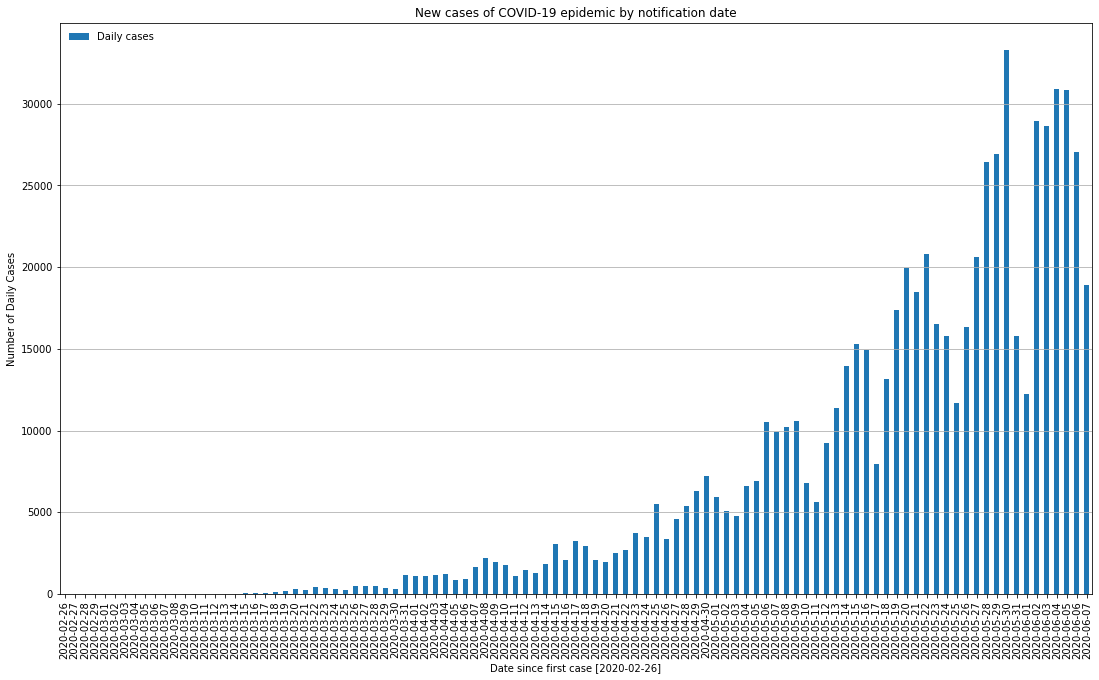

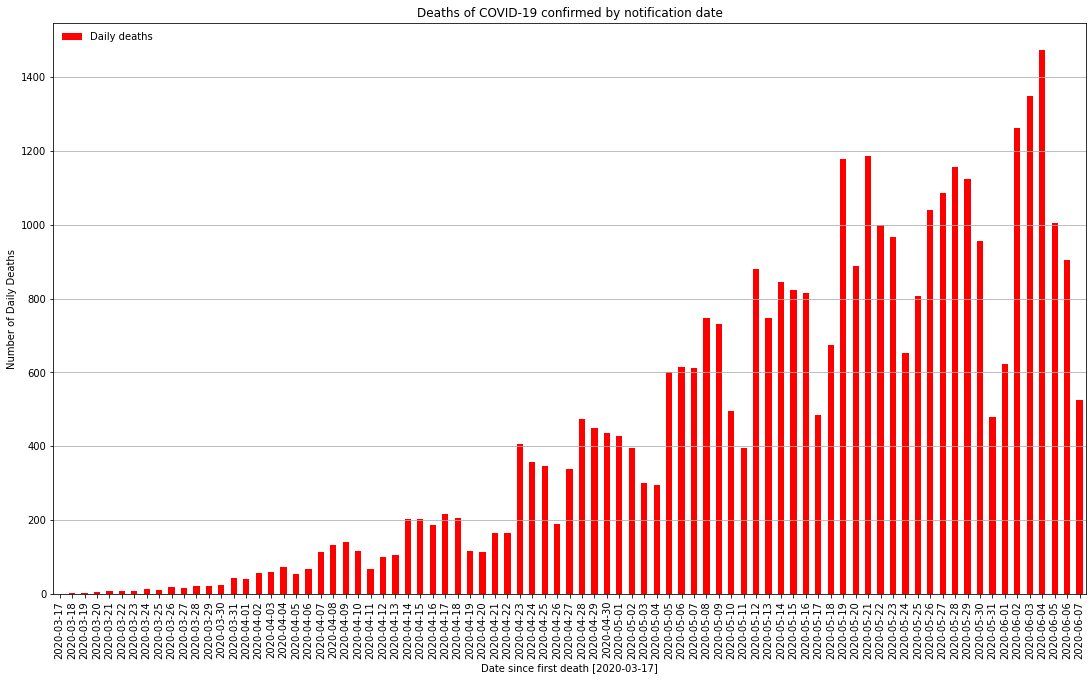

In [ ]:
index = covid_hist[covid_hist.regiao == 'Brasil'].index
df_region = covid_hist.loc[index,['data','casosNovos','obitosNovos']]

#set date as index
df_region.set_index('data',inplace=True)

#fig, ax = plt.subplots(figsize=(20,7))
#df_region.plot(secondary_y=['obitosNovos']);
ax = df_region.casosNovos.plot(kind='bar');

# specify the lines and labels of the first legend
ax.legend(['Daily cases'],loc='upper left', frameon=False)

# for p in ax.patches:
#   ax.annotate(np.round(p.get_height(),decimals=2),(p.get_x()+p.get_width()/2., p.get_height()),ha='center',va='center',xytext=(0, 10), textcoords='offset points', rotation=70) 
ax.grid(axis='y')

ax.set_title('New cases of COVID-19 epidemic by notification date')
ax.set_ylabel('Number of Daily Cases')
ax.set_xlabel('Date since first case [2020-02-26]');
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

#Plot deaths
index_start = df_region[df_region.obitosNovos.gt(0)].index[0]
df_region = df_region[df_region.index >= index_start] #Drop lines until first case

ax = df_region.obitosNovos.plot(kind='bar',color='red');

# specify the lines and labels of the first legend
ax.legend(['Daily deaths'],loc='upper left', frameon=False)

ax.grid(axis='y')

ax.set_title('Deaths of COVID-19 confirmed by notification date')
ax.set_ylabel('Number of Daily Deaths')
ax.set_xlabel('Date since first death ['+df_region.index[0]+']');
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


### Other potential data sources:  
https://covid19br.wcota.me/

https://brasil.io/dataset/covid19/caso_full/

https://covid19br.github.io/index.html